In [1]:
from concrete import fhe
import time
import numpy as np
points_array = np.array([
    [2, 3], [1, 5], [3, 2], [5, 2], [1, 1],
    [9, 4], [13, 2], [14, 13], [9, 8], [8, 0],
    [2, 10], [3, 8], [8, 12], [4, 10], [7, 7],
])
N_PTS = points_array.shape[0]
points = fhe.LookupTable(points_array.flatten())
n_neighbors = 3

def get_point(index):
    return (points[2*index], points[2*index + 1])


def all_distances(x, y):
    xs = np.arange(0, 2 * N_PTS, 2)
    ys = np.arange(1, 2 * N_PTS, 2)
    a = abs(points[xs] - x)
    b = abs(points[ys] - y)
    return a + b
# TLUs
relu = fhe.univariate(lambda x: x if x > 0 else 0)
is_positive = fhe.univariate(lambda x: 1 if x > 0 else 0)
odd_halving = fhe.univariate(lambda x: (x-1)//2 if x % 2 else 0)  

def swap(this_idx, this_dist, that_idx, that_dist):
    """
    Swaps this and that if this > that. 
    We must pass both the index and the distance for both this and that.

    Returns:
      idxmin, min, idxmax, max of this and that based on distance
    """
    diff = this_dist - that_dist
    idx = odd_halving((this_idx - that_idx) + (this_idx - that_idx) + is_positive(diff))
    dist = relu(diff)

    idx_min = this_idx - idx
    idx_max = that_idx + idx 
    dist_min = this_dist - dist
    dist_max = that_dist + dist
    return fhe.array([idx_min, dist_min, idx_max, dist_max])


@fhe.compiler({"x": "encrypted", "y": "encrypted"})
def knn(x, y):
    dist = all_distances(x, y)
    idx = list(range(N_PTS))
    for k in range(n_neighbors):
        for i in range(k+1, N_PTS):
             idx[k], dist[k], idx[i], dist[i] = swap(idx[k], dist[k], idx[i], dist[i])
    return fhe.array([get_point(idx[j]) for j in range(n_neighbors)])



/home/riad/envs/zama/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
inputset = [(4, 3), (0, 0), (15, 3), (4, 15), (9, 4), (13, 2), (14, 13), (9, 8), (8, 0), (2, 10), (3, 8), (8, 12), (4, 10), (7, 7)]
time_begin = time.time()
circuit = knn.compile(inputset)
print(f"Compilation time: {time.time() - time_begin:.2f} seconds")

Compilation time: 7.41 seconds


In [3]:
print(f"Maximum bit-width reached in the circuit: {circuit.graph.maximum_integer_bit_width()}")

Maximum bit-width reached in the circuit: 6


In [4]:
time_begin = time.time()
circuit.client.keygen()
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Key generation time: 8.71 seconds


In [5]:
x, y = 4, 3

In [6]:
ex, ey = circuit.encrypt(x, y)

In [7]:
start_time = time.time()
result = circuit.server.run(ex, ey,  evaluation_keys=circuit.client.evaluation_keys)
print("--- %s seconds ---" % (time.time() - start_time))

--- 17.16662859916687 seconds ---


In [8]:
decrypted_res = circuit.decrypt(result)

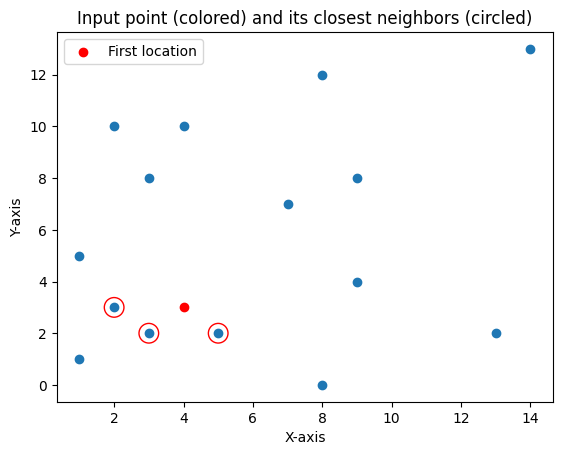

In [9]:
import matplotlib.pyplot as plt


xs = [point[0] for point in points_array]
ys = [point[1] for point in points_array]


plt.scatter(xs, ys)


plt.scatter(x, y, color='red', label='First location')

for point in decrypted_res:
    plt.scatter(point[0], point[1], marker='o', facecolor='none', edgecolor='red', s=200)


plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Input point (colored) and its closest neighbors (circled)')
plt.legend()

plt.show()
